In [9]:
import pandas as pd 
import numpy as np 
import torch.nn as nn
from pytorch_pretrained_bert import BertTokenizer, BertModel
import torch
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm

In [12]:
# CleanedData.csv contains the Amazon review dataset after applying Data Pre-Processing techniques

pd.set_option('display.max_columns', None)
df = pd.read_csv("CleanedData.csv")
print(df.head())

                                        CleanedText  label
0  love well made sturdi comfort love itveri pretti      0
1      love great upgrad origin ive mine coupl year      0
2            pillow save back love look feel pillow      0
3               miss inform use great product price      0
4               nice set good qualiti set two month      0


In [13]:
# adding tags to separate all the reviews
sentences = ["[CLS] " + str(query) + " [SEP]" for query in df["CleanedText"]]

# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [15]:
# Set the maximum sequence length. 
MAX_LEN = 334

# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [16]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [17]:
# Created Binary Clssifier for BERT Model
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [30]:

# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, df['label'].tolist(), 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs).to("cuda")
validation_inputs = torch.tensor(validation_inputs).to("cuda")
train_labels = torch.tensor(train_labels).to("cuda")
validation_labels = torch.tensor(validation_labels).to("cuda")
train_masks = torch.tensor(train_masks).to("cuda")
validation_masks = torch.tensor(validation_masks).to("cuda")

# Select a batch size for training. 
batch_size = 16

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

batch_size = 4
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [8]:
# Training the BERT Model

BATCH_SIZE = 16
EPOCHS = 10

bert_clf = BertBinaryClassifier()
# bert_clf.cuda()
bert_clf.to("cuda")
optimizer = torch.optim.Adam(bert_clf.parameters(), lr=3e-6)
pbar = tqdm(range(EPOCHS))

results = []
for epoch_num in pbar:
    bert_clf.train()
    loss = 0
    tes_loss = 0
    train_acc = []
    train_loss = []
    test_acc = []
    test_loss = []
    
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        #
        labels = labels.unsqueeze(1)
        labels = labels.float()
        #
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        
        for p, l in zip(probas, labels):

        #     print(p[0].item(), l[0].item())
            if p[0].item()>=0.5:
                if l[0] == 1:
                    train_acc += [1]
                else:
                    train_acc += [0]
            else:
                if l[0] == 0:
                    train_acc += [1]
                else:
                    train_acc += [0]
        
        loss += batch_loss.item()
        train_loss += [loss]
        
        bert_clf.zero_grad()
        batch_loss.backward()
        optimizer.step()
#         print(train_loss)

        pbar.set_description("Epoch [%d/%d]: Step [%d/%d]: Loss: %.5f" % (epoch_num, EPOCHS, step_num, int(len(train_data)/BATCH_SIZE), loss/(step_num+1)))

    bert_clf.eval()
    for step_num, batch_data in enumerate(validation_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        #
        labels = labels.unsqueeze(1)
        labels = labels.float()
        #
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        
        for p, l in zip(probas, labels):

            if p[0].item()>=0.5:
                if l[0] == 1:
                    test_acc += [1]
                else:
                    test_acc += [0]
            else:
                if l[0] == 0:
                    test_acc += [1]
                else:
                    test_acc += [0]
        
        tes_loss += batch_loss.item()
        test_loss += [tes_loss]
        
        pbar.set_description("Epoch [%d/%d]: Step [%d/%d]: Loss: %.5f" % (epoch_num, EPOCHS, step_num, int(len(validation_data)/BATCH_SIZE), tes_loss/(step_num+1)))
    
    print(np.mean(train_acc))
    print(len(train_acc))
    print(np.mean(train_loss))
    print(len(train_loss))
    print(np.mean(test_acc))
    print(len(test_acc))
    print(np.mean(test_loss))
    print(len(test_loss))
    results.append([np.mean(train_loss), np.mean(train_acc), np.mean(test_loss), np.mean(test_acc)])
    
df = pd.DataFrame(results, columns =["Train Loss", "Train Accuracy", "Test Loss", "Test Accuracy"])
df.to_csv("bert_clf.csv")

Epoch [0/10]: Step [2021/505]: Loss: 0.27575:  10%|█         | 1/10 [14:05<2:06:48, 845.36s/it]

0.8148090895037873
32345
448.2330109503371
2022
0.8807963398046247
8087
277.85491722418755
2022


Epoch [1/10]: Step [2021/505]: Loss: 0.31505:  20%|██        | 2/10 [28:16<1:53:08, 848.56s/it]

0.8932447055186273
32345
255.77579735113818
2022
0.8657103994064548
8087
315.9185113693195
2022


Epoch [2/10]: Step [2021/505]: Loss: 0.22546:  30%|███       | 3/10 [42:19<1:38:43, 846.26s/it]

0.9202040500850208
32345
193.90247065697739
2022
0.9025596636577222
8087
223.73186191160957
2022


Epoch [3/10]: Step [2021/505]: Loss: 0.21406:  40%|████      | 4/10 [56:23<1:24:31, 845.30s/it]

0.9370845571185654
32345
157.72651941046573
2022
0.9196240880425374
8087
211.54278086665767
2022


Epoch [4/10]: Step [2021/505]: Loss: 0.20999:  50%|█████     | 5/10 [1:10:27<1:10:23, 844.78s/it]

0.9496367290153037
32345
126.81499047275933
2022
0.9164090515642389
8087
208.32664317576345
2022


Epoch [5/10]: Step [2021/505]: Loss: 0.29359:  60%|██████    | 6/10 [1:24:31<56:18, 844.56s/it]  

0.960735816973257
32345
97.94932216724588
2022
0.8942747619636453
8087
290.2368215411389
2022


Epoch [6/10]: Step [2021/505]: Loss: 0.23840:  70%|███████   | 7/10 [1:38:37<42:15, 845.07s/it]

0.9702581542742309
32345
76.37830023657749
2022
0.9227154692716706
8087
232.82681917589827
2022


Epoch [7/10]: Step [2021/505]: Loss: 0.24485:  80%|████████  | 8/10 [1:52:47<28:13, 846.62s/it]

0.9761941567475653
32345
63.44219700339862
2022
0.9211079510325213
8087
239.93193372780462
2022


Epoch [8/10]: Step [2021/505]: Loss: 0.22911:  90%|█████████ | 9/10 [2:06:50<14:05, 845.54s/it]

0.9808316586798578
32345
50.245367743485026
2022
0.9298874737232595
8087
229.5242215063088
2022


Epoch [9/10]: Step [2021/505]: Loss: 0.42470: 100%|██████████| 10/10 [2:20:54<00:00, 845.43s/it]


0.9827175761323234
32345
44.727519656291804
2022
0.8983553851861011
8087
410.5240882475547
2022


In [9]:
# Save the trained BERT Model
torch.save(bert_clf.state_dict(), 'bert_clf.pth')

In [8]:
bert_clf = BertBinaryClassifier()
bert_clf.to("cuda")
bert_clf.load_state_dict(torch.load('bert_clf.pth'))
bert_clf.eval()

results= []
tes_loss = 0
test_acc = []
test_loss = []

for step_num, batch_data in enumerate(validation_dataloader):
        token_ids, masks, labels = tuple(t for t in batch_data)
        #
        labels = labels.unsqueeze(1)
        labels = labels.float()
        #
        probas = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        batch_loss = loss_func(probas, labels)
        
        for p, l in zip(probas, labels):

            if p[0].item()>=0.5:
                if l[0] == 1:
                    test_acc += [1]
                else:
                    test_acc += [0]
            else:
                if l[0] == 0:
                    test_acc += [1]
                else:
                    test_acc += [0]
        
        tes_loss += batch_loss.item()
        test_loss += [tes_loss]
        
        print("Step [%d/%d]: Loss: %.5f" % (step_num, int(len(validation_data)/16), tes_loss/(step_num+1)))

Step [0/505]: Loss: 0.06601
Step [1/505]: Loss: 0.03360
Step [2/505]: Loss: 0.02245
Step [3/505]: Loss: 0.01687
Step [4/505]: Loss: 0.02741
Step [5/505]: Loss: 0.02311
Step [6/505]: Loss: 0.05494
Step [7/505]: Loss: 0.04810
Step [8/505]: Loss: 0.04346
Step [9/505]: Loss: 0.11236
Step [10/505]: Loss: 0.11641
Step [11/505]: Loss: 0.11818
Step [12/505]: Loss: 0.10915
Step [13/505]: Loss: 0.10457
Step [14/505]: Loss: 0.10568
Step [15/505]: Loss: 0.09911
Step [16/505]: Loss: 0.15976
Step [17/505]: Loss: 0.23658
Step [18/505]: Loss: 0.22414
Step [19/505]: Loss: 0.21295
Step [20/505]: Loss: 0.31048
Step [21/505]: Loss: 0.29638
Step [22/505]: Loss: 0.36115
Step [23/505]: Loss: 0.34617
Step [24/505]: Loss: 0.33831
Step [25/505]: Loss: 0.32536
Step [26/505]: Loss: 0.31332
Step [27/505]: Loss: 0.30214
Step [28/505]: Loss: 0.29496
Step [29/505]: Loss: 0.28514
Step [30/505]: Loss: 0.27596
Step [31/505]: Loss: 0.26737
Step [32/505]: Loss: 0.26379
Step [33/505]: Loss: 0.25612
Step [34/505]: Loss: 0.2

In [10]:
len(test_loss)

2022

In [31]:
# Test the BERT Model for Amazon Reviews Classification
import random

bert_clf = BertBinaryClassifier()
bert_clf.to("cuda")
bert_clf.load_state_dict(torch.load('bert_clf.pth'))
bert_clf.eval()
loss = 0

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, df['label'].tolist(), 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)
test_results = []
acc = []
test_loss = []

for _ in tqdm(range(10)):
    
    args = random.choices(range(len(validation_inputs)), k=500)
    
    inputs = validation_inputs[args]
    labels = validation_labels[args]
    masks = validation_masks[args]
    
    probas = bert_clf(inputs, masks)
    
    batch_loss = loss_func(probas, labels)
    
    test_acc = []
    
    for p, l in tqdm(zip(probas, labels)):

    #     print(p[0].item(), l[0].item())
        if p[0].item()>=0.5:
            if l[0] == 1:
                test_acc += [1]
            else:
                test_acc += [0]
        else:
            if l[0] == 0:
                test_acc += [1]
            else:
                test_acc += [0]

    loss += batch_loss.item()
    test_loss += [loss]
    acc += [np.mean(test_acc)]
    
    test_results.append([loss, np.mean(test_acc)])
    
df = pd.DataFrame(test_results, columns =["Test Loss", "Test Accuracy"])
df.to_csv("bert_clf_test.csv")

print(acc, test_loss)

In [12]:
# Plot of Accuracy and Loss of Train and Test data

import matplotlib.pyplot as plt
%matplotlib inline


filename = 'bert_clf.csv'
# scaler = MinMaxScaler()
history = pd.read_csv(filename, sep=',')
train_acc = history['Train Accuracy']
train_loss = history['Train Loss']
test_acc = history['Test Accuracy']
test_loss = history['Test Loss']

epochs = range(10)

plt.figure(figsize=(32,10))
plt.subplot(2,2,1)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.title('Accuracy')
plt.legend(loc=0)

plt.subplot(2,2,2)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.title('Loss')
plt.legend(loc=0)


plt.subplot(2,2,3)
plt.plot(epochs, test_acc, 'r', label='Test Accuracy')
plt.legend(loc=0)

plt.subplot(2,2,4)
plt.plot(epochs, test_loss, 'r', label='Test Loss')
plt.legend(loc=0)

# plt.savefig('train_history.png')
# plt.savefig('test_history.png')
# plt.savefig('Accuracy_Loss_Plots.png')
# plt.show()

93.85716494048538 151.51954956486765 90.51440583652776 264.04185987462427


<BarContainer object of 2 artists>

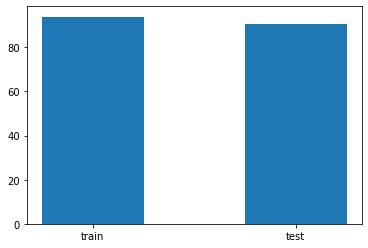

In [14]:
# bar chart of Training and Testing Accuracy

train_ac = sum(train_acc)/len(train_acc) * 100
test_ac = sum(test_acc)/len(test_acc) * 100

train_los = sum(train_loss)/len(train_loss)
test_los = sum(test_loss)/len(test_loss)

print(train_ac, train_los, test_ac, test_los)

plt.bar(['train', 'test'],[train_ac, test_ac], width = 0.5)